# Data exploration of geoclim and GBS sequencing data from wild coffee tree samples

## About the data
### Source
Hamon P, Grover CE, Davis AP, Rakotomalala JJ, Raharimalala NE, Albert VA, Sreenath HL, Stoffelen P, Mitchell SE, Couturon E, Hamon S, de Kochko A, Crouzillat D, Rigoreau M, Sumirat U, Akaffou S, Guyot R. Genotyping-by-sequencing provides the first well-resolved phylogeny for coffee (Coffea) and insights into the evolution of caffeine content in its species: GBS coffee phylogeny and the evolution of caffeine content. Mol Phylogenet Evol. 2017 Apr;109:351-361. doi: 10.1016/j.ympev.2017.02.009. Epub 2017 Feb 16. PMID: 28212875.

### Metadata
Metadata table in [data directory](coffeaPhyloGeo/data/geoclim/geospatial/coff_madag_species_summary.xlsx)

**Genetic data :**
GBS/Rad-Seq from nuclear DNA. Data cleaning, ref-genome alignement + SNP concat #TODO

**geoclim data :**
GPS positions available in metadata table. To use to extract information on the [Madaclim](https://madaclim.cirad.fr/) database.

---

**All required imports and utils**

In [96]:
import pandas as pd
from pathlib import Path
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from definitions import *
import geopandas as gpd
from shapely.geometry import Point
import calendar 

## Climate data extraction

### Paths and file configs
See definitions.py for dir paths + config.yaml ref

In [97]:
# File names
print("\n".join([METADATA_RAW, GPS_ALL,GPS_GBS_ONLY, MADACLIM_CURRENT_TIF]))

coff_madag_species_summary.xlsx
species_locations_all_positions.csv
species_locations_gbs_only.csv
madaclim_current.tif


### GPS position extraction from metadata + cleaning
Generate 2 csv files for 2 subsets using Pandas :
- all specimens WITH GPS positions (df_gps_all)
- only specimens with BOTH GPS and SNP.fasta (df_gbs_only)

In [98]:
# Read from raw table
df = pd.read_excel(GEOSPATIAL_DIR / METADATA_RAW, decimal=",")

# Remove blank rows
df = df.dropna(how="all")
df["GBS sequence"] = df["GBS sequence"].str.rstrip()    #* \n still present after stripping

# Remove \n in Botanical series
df = df.replace(r"\n","", regex=True)

# Converting to proper NaN and reordering
df = df.replace({"-": np.nan, "NO POSITION": np.nan})
df = df[["Species", "Species code", "Population code", "GBS sequence", "Botanical series", "Genome size (2C. pg)", "Latitude", "Longitude"]]
# Remove NO from AND2 species
df["Longitude"] = df["Longitude"].str.replace("NO ", "")
df["Longitude"] = df["Longitude"].str.replace(",", ".").astype(float)

df.head()


,Species,Species code,Population code,GBS sequence,Botanical series,Genome size (2C. pg),Latitude,Longitude
0,C.abbayesii,ABA,A601,C_abbayesii_A601,Millotii,1.25,-24.7541,46.862400
1,C.ambodirianenis,AMB,A572,C_ambodirianensis_A572,Millotii,1.27,-18.4522,48.943300
2,C.ambongensis,AMBON,BR071,C_ambongensis,Baracoffea,1.16,-15.5745833,46.419806
3,C.ankaranensis,ANK1,A525,C_ankaranensis_A525,Multiflorae,1.17,-12.9491,49.543300
4,C.ankaranensis,ANK2,A808,NaN,Multiflorae,1.17,-12.8491,49.543300


In [99]:
# Keep df for all species WITH GPS positions and reorder
df_gps_all = df
df_gps_all = df_gps_all.dropna(subset=["Latitude", "Longitude"])
print(f"Number of samples for all specimens WITH GPS : {len(df_gps_all)}")
df_gps_all

Number of samples for all specimens WITH GPS : 51


,Species,Species code,Population code,GBS sequence,Botanical series,Genome size (2C. pg),Latitude,Longitude
0,C.abbayesii,ABA,A601,C_abbayesii_A601,Millotii,1.25,-24.7541,46.862400
1,C.ambodirianenis,AMB,A572,C_ambodirianensis_A572,Millotii,1.27,-18.4522,48.943300
2,C.ambongensis,AMBON,BR071,C_ambongensis,Baracoffea,1.16,-15.5745833,46.419806
3,C.ankaranensis,ANK1,A525,C_ankaranensis_A525,Multiflorae,1.17,-12.9491,49.543300
4,C.ankaranensis,ANK2,A808,NaN,Multiflorae,1.17,-12.8491,49.543300
5,C.arenesiana,ARE,A403,C_arenesiana_A403,Multiflorae,1.11,-18.9333,48.200000
6,C.augagneuri,AUGA,A966,C_augagneuri_A966,Subterminales,1.18,-12.7333,49.166660
7,C.bertrandii,BERT,A5,C_bertrandii_A5,Multiflorae,1.22,-25.01666,46.633300
8,C.betamponensis,BET,A573,NaN,Multiflorae,1.26,-17.93,49.200000
9,C.bissetiae,BISS,BR031,C_bissetiae,Baracoffea,1.19,-16.315048,46.812299


In [100]:
# Clean for missing GBS sequences
df_gbs_only = df_gps_all.dropna()
print(f"Number of samples for specimens with BOTH GPS AND genetic data : {len(df_gbs_only)}")
df_gbs_only

Number of samples for specimens with BOTH GPS AND genetic data : 41


,Species,Species code,Population code,GBS sequence,Botanical series,Genome size (2C. pg),Latitude,Longitude
0,C.abbayesii,ABA,A601,C_abbayesii_A601,Millotii,1.25,-24.7541,46.862400
1,C.ambodirianenis,AMB,A572,C_ambodirianensis_A572,Millotii,1.27,-18.4522,48.943300
2,C.ambongensis,AMBON,BR071,C_ambongensis,Baracoffea,1.16,-15.5745833,46.419806
3,C.ankaranensis,ANK1,A525,C_ankaranensis_A525,Multiflorae,1.17,-12.9491,49.543300
5,C.arenesiana,ARE,A403,C_arenesiana_A403,Multiflorae,1.11,-18.9333,48.200000
6,C.augagneuri,AUGA,A966,C_augagneuri_A966,Subterminales,1.18,-12.7333,49.166660
7,C.bertrandii,BERT,A5,C_bertrandii_A5,Multiflorae,1.22,-25.01666,46.633300
9,C.bissetiae,BISS,BR031,C_bissetiae,Baracoffea,1.19,-16.315048,46.812299
10,C.boinensis,BOIN,BR051,C_boinensis,Baracoffea,1.15,-16.295741,46.826763
11,C.boiviniana,BOI,A980,C_boiviniana_A980,Subterminales,1.00,-13.35,49.880000


**Save as csv to data/geoclim/geospatial/**

In [101]:
# Save cleaned data to csv in geospatial dir
# df_gps_all.to_csv(GEOSPATIAL_DIR / GPS_ALL, index=False)  # All positions available
# df_gbs_only.to_csv(GEOSPATIAL_DIR / GPS_GBS_ONLY, index=False)    # Species with both gbs AND positions

### Raster file basic manipulations

In [102]:
# Open raster file
raster_mada = rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF)
print(f"File opened ? {not(raster_mada.closed)}")


File opened ? True


In [103]:
# Check for dtypes
if len(set(raster_mada.dtypes)) > 1 :
    print(f"Raster file {MADACLIM_CURRENT_TIF} has more than one dtypes")
    print(set(raster_mada.dtypes))
else:
    print(f"Raster file {MADACLIM_CURRENT_TIF} has only {set(raster_mada.dtypes)}")    

# Get dict for all band dtypes combinations
bands_types = {i: dtype for i, dtype in zip(raster_mada.indexes, raster_mada.dtypes)}
# print(bands_types)

Raster file madaclim_current.tif has only {'int16'}


In [104]:
# Number of bands total
print(f"{MADACLIM_CURRENT_TIF} has {len(raster_mada.indexes)} bands")

madaclim_current.tif has 70 bands


In [105]:
# Get CRS + bounds
print(f"CRS of {MADACLIM_CURRENT_TIF} : {raster_mada.crs}")

CRS of madaclim_current.tif : EPSG:32738


In [106]:
raster_mada.bounds

BoundingBox(left=298000.0, bottom=7155000.0, right=1101000.0, top=8683000.0)

In [107]:
# band1
band1 = raster_mada.read(1)
band1[raster_mada.height // 2, raster_mada.width // 2]

120

In [108]:
#nodata value
raster_mada.nodata

-32768.0

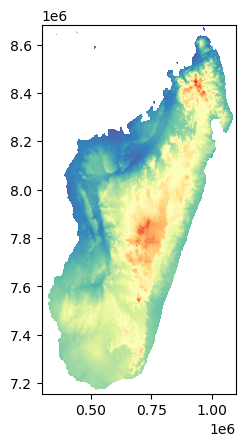

<AxesSubplot: >

In [109]:
# Plot raster
rasterio.plot.show(raster_mada, cmap="Spectral")

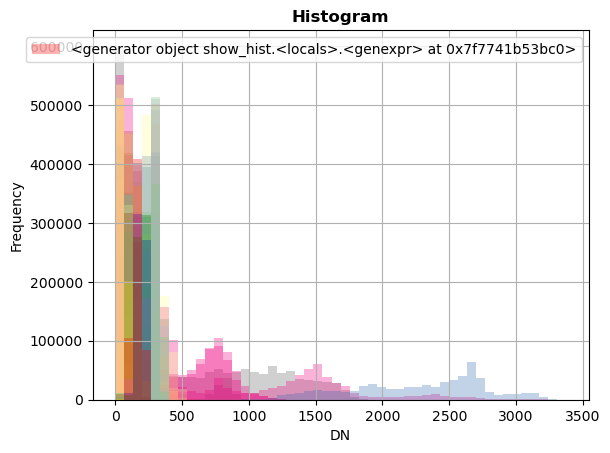

In [110]:
# Histogram
rasterio.plot.show_hist(
    raster_mada, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram"
)

DN = Digital Number
Represents distributions of all 70 bands on 1 graph

**NEED TO TRANSFORM -32768 DATA POINTS TO np.nan**

### Defining the climate variables to get from raster

Get info for bioclim vars

In [111]:
# bioclim vars
def label_bioclim_vars():
    bio1_bio19 = [(k, v["longname"]) for k,v in config["bioclim_defs"].items()]
    bio_layers = {}
    for i, bio in enumerate(bio1_bio19, start=37):
        bio_layers[f"layer{i}"] = bio
    return bio_layers   


Get info for monthly vars

In [112]:
# Layers description for monthly vars
l1_12 = "Monthly minimum temperature (C x 10)"
l13_24 = "Monthly maximum temperature (C x 10)"
l25_36 = "Monthly total precipitation (mm.month-1)"
l56_67 = "Monthly potential evapotranspiration (mm.month-1)"

In [113]:
def label_monthly_vars(description, first_layer):
    layers = {}
    monthly_vars = list(zip([description for i in range(1,13)], calendar.month_name[1:]))
    for i, month in enumerate(monthly_vars, start=first_layer):
        layers[f"layer{i}"] = month
    return layers


Get info for annual vars

In [114]:
l68 = {"layer68" : "Annual potential evapotranspiration (mm)"}
l69 = {"layer69" : "Annual climatic water deficit (mm)"}
l70 = {"layer70" : "Number of dry months in the year"}

Generate all vars dictionary

In [115]:
# Layers 1 to 12
mada_layers = {}
temp_layers = label_monthly_vars(l1_12, 1)
mada_layers.update(temp_layers)

# Layers 13 to 24
temp_layers = label_monthly_vars(l13_24, 13)
mada_layers.update(temp_layers)

# Layers 25 to 36
temp_layers = label_monthly_vars(l25_36, 25)
mada_layers.update(temp_layers)

# Layers 37 to 55 (bioclim)
temp_layers = label_bioclim_vars()
mada_layers.update(temp_layers)

# Layers 56 to 67
temp_layers = label_monthly_vars(l56_67, 56)
mada_layers.update(temp_layers)

# Layers 68 to 70
mada_layers.update(l68)
mada_layers.update(l69)
mada_layers.update(l70)

mada_layers

{'layer1': ('Monthly minimum temperature (C x 10)', 'January'),
 'layer2': ('Monthly minimum temperature (C x 10)', 'February'),
 'layer3': ('Monthly minimum temperature (C x 10)', 'March'),
 'layer4': ('Monthly minimum temperature (C x 10)', 'April'),
 'layer5': ('Monthly minimum temperature (C x 10)', 'May'),
 'layer6': ('Monthly minimum temperature (C x 10)', 'June'),
 'layer7': ('Monthly minimum temperature (C x 10)', 'July'),
 'layer8': ('Monthly minimum temperature (C x 10)', 'August'),
 'layer9': ('Monthly minimum temperature (C x 10)', 'September'),
 'layer10': ('Monthly minimum temperature (C x 10)', 'October'),
 'layer11': ('Monthly minimum temperature (C x 10)', 'November'),
 'layer12': ('Monthly minimum temperature (C x 10)', 'December'),
 'layer13': ('Monthly maximum temperature (C x 10)', 'January'),
 'layer14': ('Monthly maximum temperature (C x 10)', 'February'),
 'layer15': ('Monthly maximum temperature (C x 10)', 'March'),
 'layer16': ('Monthly maximum temperature (C 

### Creating Point objects for each specimen

Subset df

In [116]:
df_positions_all = df_gps_all[["Species code", "Longitude", "Latitude"]]
df_positions_all.head()

,Species code,Longitude,Latitude
0,ABA,46.862400,-24.7541
1,AMB,48.943300,-18.4522
2,AMBON,46.419806,-15.5745833
3,ANK1,49.543300,-12.9491
4,ANK2,49.543300,-12.8491


Create shapely.Point objects from GPS coordinates

In [117]:
# Beware of lon/lat order in instance creation
points = [Point(float(row["Longitude"]), float(row["Latitude"])) for index, row in df_positions_all.iterrows()]
points[0:10]

[<POINT (46.862 -24.754)>,
 <POINT (48.943 -18.452)>,
 <POINT (46.42 -15.575)>,
 <POINT (49.543 -12.949)>,
 <POINT (49.543 -12.849)>,
 <POINT (48.2 -18.933)>,
 <POINT (49.167 -12.733)>,
 <POINT (46.633 -25.017)>,
 <POINT (49.2 -17.93)>,
 <POINT (46.812 -16.315)>]

Create GeoPandas dataframe

In [118]:
# Original coordinates under GPS format aka epsg:4326
gdf_postions_all = "Reset"
gdf_postions_all = gpd.GeoDataFrame(df_positions_all, geometry=points, crs=4326)
gdf_postions_all.head()

,Species code,Longitude,Latitude,geometry
0,ABA,46.862400,-24.7541,POINT (46.86240 -24.75410)
1,AMB,48.943300,-18.4522,POINT (48.94330 -18.45220)
2,AMBON,46.419806,-15.5745833,POINT (46.41981 -15.57458)
3,ANK1,49.543300,-12.9491,POINT (49.54330 -12.94910)
4,ANK2,49.543300,-12.8491,POINT (49.54330 -12.84910)


Check CRS + transform to Madaclim_current.tif raster CRS

In [119]:
gdf_postions_all.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [120]:
gdf_postions_all = gdf_postions_all.to_crs(32738)
gdf_postions_all.head()


,Species code,Longitude,Latitude,geometry
0,ABA,46.862400,-24.7541,POINT (688328.240 7260998.023)
1,AMB,48.943300,-18.4522,POINT (916635.952 7955240.629)
2,AMBON,46.419806,-15.5745833,POINT (652237.905 8277614.406)
3,ANK1,49.543300,-12.9491,POINT (993250.150 8564104.062)
4,ANK2,49.543300,-12.8491,POINT (993446.882 8575194.181)


In [121]:
gdf_postions_all["geometry"].x  #lon


0     6.883282e+05
1     9.166360e+05
2     6.522379e+05
3     9.932502e+05
4     9.934469e+05
5     8.370729e+05
6     9.526787e+05
7     6.648080e+05
8     9.451234e+05
9     6.936213e+05
10    6.951862e+05
11    1.029018e+06
12    9.543074e+05
13    1.042589e+06
14    9.470097e+05
15    7.616138e+05
16    8.303481e+05
17    1.036668e+06
18    7.872816e+05
19    9.392630e+05
20    9.552306e+05
21    5.072376e+05
22    1.038751e+06
23    6.883384e+05
24    8.049768e+05
25    7.572472e+05
26    7.852460e+05
27    7.852466e+05
28    1.804919e+06
29    8.406174e+05
30    8.388229e+05
31    8.167930e+05
32    7.503346e+05
33    9.568388e+05
34    8.050362e+05
35    6.581691e+05
36    1.044715e+06
37    9.645095e+05
38    1.008285e+06
39    9.697909e+05
40    1.036778e+06
41    6.245951e+05
42    8.399890e+05
43    9.649108e+05
44    8.037906e+05
45    8.264730e+05
46    8.423441e+05
47    1.052801e+06
48    8.050338e+05
56    1.804938e+06
57    1.821823e+06
dtype: float64

In [122]:
gdf_postions_all.crs

<Derived Projected CRS: EPSG:32738>
Name: WGS 84 / UTM zone 38S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 42°E and 48°E, southern hemisphere between 80°S and equator, onshore and offshore. Madagascar.
- bounds: (42.0, -80.0, 48.0, 0.0)
Coordinate Operation:
- name: UTM zone 38S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

View points on raster map

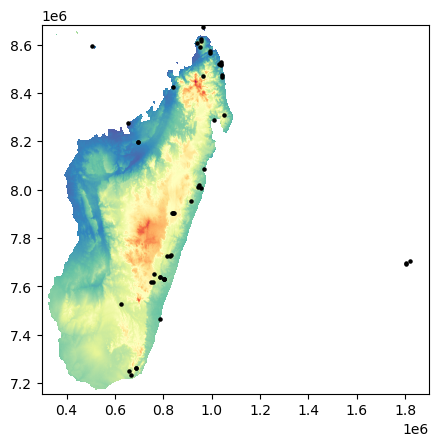

In [123]:
# Plotting with matplotlib.pyplot, rasterio.show and GeoPandas.plot modules
with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_mada:

    fig, ax = plt.subplots()
    ax = rasterio.plot.show(raster_mada, ax=ax, cmap="Spectral")
    gdf_postions_all.plot(ax=ax, color="black", markersize=5)


OK nice it works, we can improve visualization later

### Using GeoPandas with Rasterio to sample point data

In [127]:
# Open raster file
raster_mada = rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF)
print(f"File opened ? {not(raster_mada.closed)}")

File opened ? True


In [124]:
gdf_postions_all.head()

,Species code,Longitude,Latitude,geometry
0,ABA,46.862400,-24.7541,POINT (688328.240 7260998.023)
1,AMB,48.943300,-18.4522,POINT (916635.952 7955240.629)
2,AMBON,46.419806,-15.5745833,POINT (652237.905 8277614.406)
3,ANK1,49.543300,-12.9491,POINT (993250.150 8564104.062)
4,ANK2,49.543300,-12.8491,POINT (993446.882 8575194.181)


Extract for all coords + create cols on geodf

In [168]:
# Create a list of coordinates under EPSG:32738
coord_list = [(x,y) for x,y in zip(gdf_postions_all["geometry"].x, gdf_postions_all["geometry"].y)]
coord_list[0:5]

[(688328.2403248843, 7260998.022932809),
 (916635.9521871379, 7955240.6291522365),
 (652237.9054559749, 8277614.406156755),
 (993250.1503363773, 8564104.062130136),
 (993446.8824191699, 8575194.181379195)]

In [165]:
all_vals = [x for x in raster_mada.sample(coord_list)]
print(all_vals[0])

[ 155  195  188  171  136  122  120  124  138  173  188  196  276  295
  288  281  266  243  235  240  259  286  293  297   57  181  169   73
   64   73   58   57   44  105  175  204  215  112   63 2597  297  120
  177  238  186  238  180 1260  204   44   56  484  159  484  188   92
  125  113   94   67   50   44   47   60   92  110  123 1022   77    4]


We have all the data in a list of 51 (each specimens) arrays each containing 70 elements (each climvars)

We need to get this information ordered unto the GeoPandas df

In [169]:
for i, arr in enumerate(all_vals):
    # for j in arr:
    #     print(j)
    print(arr)
    if i == 0:
        break

[ 155  195  188  171  136  122  120  124  138  173  188  196  276  295
  288  281  266  243  235  240  259  286  293  297   57  181  169   73
   64   73   58   57   44  105  175  204  215  112   63 2597  297  120
  177  238  186  238  180 1260  204   44   56  484  159  484  188   92
  125  113   94   67   50   44   47   60   92  110  123 1022   77    4]


In [171]:
gdf_postions_all.loc[0, 'test'] = all_vals[0][0]
gdf_postions_all.head()

,Species code,Longitude,Latitude,geometry,test
0,ABA,46.862400,-24.7541,POINT (688328.240 7260998.023),155.0
1,AMB,48.943300,-18.4522,POINT (916635.952 7955240.629),NaN
2,AMBON,46.419806,-15.5745833,POINT (652237.905 8277614.406),NaN
3,ANK1,49.543300,-12.9491,POINT (993250.150 8564104.062),NaN
4,ANK2,49.543300,-12.8491,POINT (993446.882 8575194.181),NaN


TODO: FIND A METHOD TO ITERATE OVER ARRAYS AND POPULATE DF